In [12]:
import numpy as np
import os
import pandas as pd
import subprocess
import json
import matplotlib.pyplot as plt
import seaborn as sns
from apxinfer.simulation import utils as simutils
from apxinfer.simulation.utils import task_meta
from apxinfer.examples.all_tasks import ALL_CLS_TASKS, ALL_REG_TASKS


CompletedProcess(args='cd /home/ckchang/ApproxInfer/apxinfer/examples && python evaluate_all.py --exp tripsralfv3 --model lgbm --phase biathlon-policy', returncode=0, stdout='skip /home/ckchang/.cache/biathlon/vldb2024/final/tripsralfv3/seed-0/online/lgbm/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/pest-error-biathlon-128-0/qinf-biathlon/scheduler-optimizer-5-2/evals_conf-0.05-1.4-0.95-60.0-2048.0-1000.json\nskip /home/ckchang/.cache/biathlon/vldb2024/final/tripsralfv3/seed-0/online/lgbm/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/pest-error-biathlon-128-0/qinf-biathlon/scheduler-optimizerexpinit-5-2/evals_conf-0.05-1.4-0.95-60.0-2048.0-1000.json\nskip /home/ckchang/.cache/biathlon/vldb2024/final/tripsralfv3/seed-0/online/lgbm/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/pest-error-biathlon-128-0/qinf-biathlon/scheduler-optimizerexpbatch-5-2/evals_conf-0.05-1.4-0.95-60.0-2048.0-1000.json\nskip /home/ckchang/.cache/biathlon/vldb2024/final/tripsralfv3/seed-0/online/lgbm/ncores-1/ldnthreads-0

In [38]:

task_name = "tripsralfv3"
task_name = "tickralfv2"
task_name = "batteryv2"
task_name = "turbofan"
# task_name = "machineryralf"
# task_name = "tdfraudralf2d"
# task_name = "studentqnov2subset"
model = task_meta[task_name]['model']
agg_qids = task_meta[task_name]['agg_ids']

cmd = f"cd /home/ckchang/ApproxInfer/apxinfer/examples && python evaluate_all.py --exp {task_name} --model {model} --phase biathlon-policy"
result = subprocess.run(cmd, capture_output=True, text=True, shell=True, check=True)
result

CompletedProcess(args='cd /home/ckchang/ApproxInfer/apxinfer/examples && python evaluate_all.py --exp turbofan --model rf --phase biathlon-policy', returncode=0, stdout='skip /home/ckchang/.cache/biathlon/vldb2024/final/turbofan/seed-0/online/rf/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/pest-error-biathlon-128-0/qinf-biathlon/scheduler-optimizer-5-9/evals_conf-0.05-4.88-0.95-60.0-2048.0-1000.json\nskip /home/ckchang/.cache/biathlon/vldb2024/final/turbofan/seed-0/online/rf/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/pest-error-biathlon-128-0/qinf-biathlon/scheduler-optimizerexpinit-5-9/evals_conf-0.05-4.88-0.95-60.0-2048.0-1000.json\nskip /home/ckchang/.cache/biathlon/vldb2024/final/turbofan/seed-0/online/rf/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/pest-error-biathlon-128-0/qinf-biathlon/scheduler-optimizerexpbatch-5-9/evals_conf-0.05-4.88-0.95-60.0-2048.0-1000.json\nskip /home/ckchang/.cache/biathlon/vldb2024/final/turbofan/seed-0/online/rf/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/

In [39]:
stdout = result.stdout
eval_paths = [s.replace('skip ', '') for s in stdout.split('\n')]
eval_paths = [p for p in eval_paths if p != '']

In [40]:
data = []
for path in eval_paths:
    with open(path, 'r') as f:
        item = {}
        settings = path.split('/')
        for setting in settings:
            if setting.startswith('pest'):
                item['pest'] = setting.split('-')[2]
            elif setting.startswith('qinf'):
                item['qinf'] = setting.split('-')[1]
            elif setting.startswith('scheduler'):
                item['scheduler'] = setting.split('-')[1]
        evals = json.load(f)
        acc_metric = 'r2' if task_name in ALL_REG_TASKS else 'f1'
        item = {**item,
            'accuracy': evals['evals_to_gt'][acc_metric],
            'similarity': evals['evals_to_ext'][acc_metric],
            'latency': evals['avg_ppl_time'],
            'qtime': evals['avg_query_time'],
            'overhead': evals['avg_pred_time'] + evals['avg_scheduler_time'],
            'avg_samples': np.mean(np.array(evals['avg_sample_query'])[agg_qids])
        }
        data.append(item)

In [41]:
df = pd.DataFrame(data)
df['policy'] = df['pest'] + '-' + df['qinf'] + '-' + df['scheduler']
df = df.sort_values(['pest', 'qinf', 'scheduler'])
df.set_index(['pest', 'qinf', 'scheduler'], inplace=True)
# dedup
df = df[~df.index.duplicated(keep='first')]
df

accuracy  similarity   latency  \
pest     qinf         scheduler                                           
MC       prevgradient optimizer          0.923287    0.995921  2.642703   
                      stepgradient       0.923103    0.996176  2.921887   
         yufei        optimizer          0.924014    0.996052  2.662056   
                      stepgradient       0.923107    0.995891  2.968634   
biathlon biathlon     optimizer          0.922458    0.995937  0.298608   
                      optimizerexpbatch  0.923418    0.996634  0.295245   
                      optimizerexpinit   0.922765    0.996953  0.306390   
                      random             0.923032    0.995691  0.541446   
                      stepgradient       0.922458    0.995937  0.297301   
                      uniform            0.922458    0.995937  0.468127   
                      uniformexpbatch    0.923418    0.996634  0.519223   
                      uniformexpinit     0.924391    0.996601  0.495805   
         prevgradient optimizer          0.922770    0.996162  4.184263   
                      stepgradient       0.922462    0.996343  4.631425   
         yufei        optimizer          0.922805    0.996171  3.522772   
                      stepgradient       0.922129    0.996306  3.915806   

                                            qtime  overhead  avg_samples  \
pest     qinf         scheduler                                            
MC       prevgradient optimizer          0.525039  2.114569     0.121027   
                      stepgradient       0.564295  2.353821     0.129597   
         yufei        optimizer          0.525269  2.133684     0.121951   
                      stepgradient       0.567333  2.397478     0.130546   
biathlon biathlon     optimizer          0.232669  0.065065     0.055358   
                      optimizerexpbatch  0.243234  0.051220     0.058349   
                      optimizerexpinit   0.257389  0.048243     0.061769   
                      random             0.365682  0.172762     0.084239   
                      stepgradient       0.230887  0.065565     0.055358   
                      uniform            0.406500  0.060522     0.097438   
                      uniformexpbatch    0.469730  0.048592     0.113446   
                      uniformexpinit     0.440712  0.054110     0.105982   
         prevgradient optimizer          0.596752  3.583787     0.137334   
                      stepgradient       0.644174  3.982768     0.147321   
         yufei        optimizer          0.530403  2.989204     0.122900   
                      stepgradient       0.571061  3.340886     0.131443   

                                                                      policy  
pest     qinf         scheduler                                               
MC       prevgradient optimizer                    MC-prevgradient-optimizer  
                      stepgradient              MC-prevgradient-stepgradient  
         yufei        optimizer                           MC-yufei-optimizer  
                      stepgradient                     MC-yufei-stepgradient  
biathlon biathlon     optimizer                  biathlon-biathlon-optimizer  
                      optimizerexpbatch  biathlon-biathlon-optimizerexpbatch  
                      optimizerexpinit    biathlon-biathlon-optimizerexpinit  
                      random                        biathlon-biathlon-random  
                      stepgradient            biathlon-biathlon-stepgradient  
                      uniform                      biathlon-biathlon-uniform  
                      uniformexpbatch      biathlon-biathlon-uniformexpbatch  
                      uniformexpinit        biathlon-biathlon-uniformexpinit  
         prevgradient optimizer              biathlon-prevgradient-optimizer  
                      stepgradient        biathlon-prevgradient-stepgradient  
         yufei        optimizer                     biath

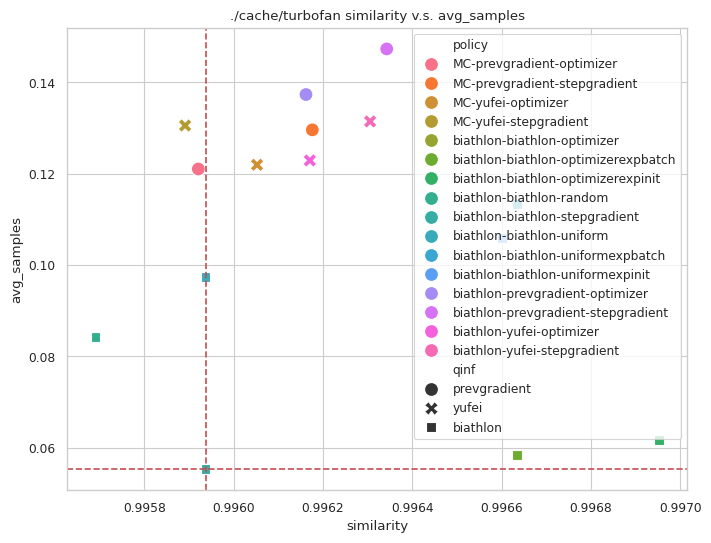

In [42]:
# plot the similarity v.s. avg_samples

sns.set_theme(style="whitegrid")
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df, x='similarity', y='avg_samples', hue='policy', style='qinf', ax=ax, s=100)
# poliocy biathlon-biathlon-optimizer is ours, should be marked with a star and vertical line and horizontal line
biathlon_biathlon_optimizer = df.loc[('biathlon', 'biathlon', 'optimizer')]
ax.axvline(biathlon_biathlon_optimizer['similarity'], color='r', linestyle='--')
ax.axhline(biathlon_biathlon_optimizer['avg_samples'], color='r', linestyle='--')
# ax.scatter(biathlon_biathlon_optimizer['similarity'], biathlon_biathlon_optimizer['avg_samples'], marker='*', color='r', s=100)

os.makedirs('./cache', exist_ok=True)
plt.title(f'./cache/{task_name} similarity v.s. avg_samples')
plt.savefig(f'./cache/{task_name}_similarity_vs_avg_samples.png')
plt.show()

In [53]:
tasks = ['tripsralfv3', 'tickralfv2', 'batteryv2', 'turbofan', 'tdfraudralf2d', 'machineryralf', 'studentqnov2subset']
sns.set_theme(style="whitegrid")
sns.set_context("paper")

In [59]:
def extract_evals(eval_paths, agg_qids):
    data = []
    for path in eval_paths:
        with open(path, 'r') as f:
            item = {}
            settings = path.split('/')
            for setting in settings:
                if setting.startswith('pest'):
                    item['pest'] = setting.split('-')[2]
                elif setting.startswith('qinf'):
                    item['qinf'] = setting.split('-')[1]
                elif setting.startswith('scheduler'):
                    item['scheduler'] = setting.split('-')[1]
                elif setting.startswith('bs'):
                    item['bs_type'] = setting.split('-')[1]
            item['bs_type'] = item.get('bs_type', "fstd")
            evals = json.load(f)
            acc_metric = 'r2' if task_name in ALL_REG_TASKS else 'f1'
            item = {**item,
                'accuracy': evals['evals_to_gt'][acc_metric],
                'similarity': evals['evals_to_ext'][acc_metric],
                'latency': evals['avg_ppl_time'],
                'qtime': evals['avg_query_time'],
                'overhead': evals['avg_pred_time'] + evals['avg_scheduler_time'],
                'avg_samples': np.mean(np.array(evals['avg_sample_query'])[agg_qids])
            }
            data.append(item)
    df = pd.DataFrame(data)
    return df

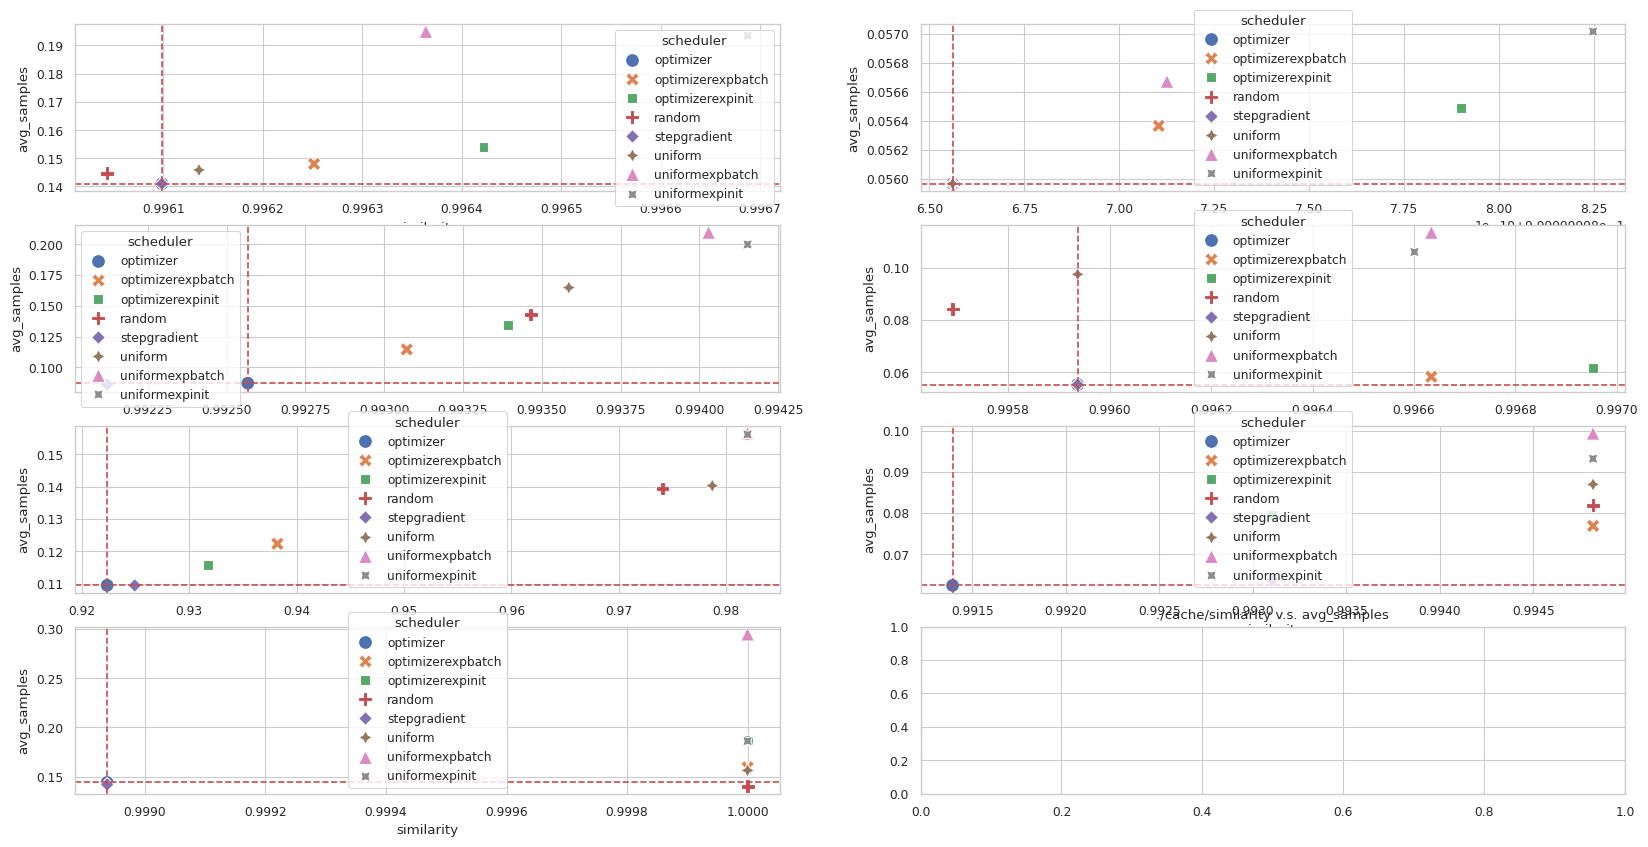

In [55]:
def plot_vary_scheduler(task_name: str, ax: plt.Axes):
    model = task_meta[task_name]['model']
    agg_qids = task_meta[task_name]['agg_ids']

    cmd = f"cd /home/ckchang/ApproxInfer/apxinfer/examples && python evaluate_all.py --exp {task_name} --model {model} --phase biathlon-policy"
    result = subprocess.run(cmd, capture_output=True, text=True, shell=True, check=True)
    stdout = result.stdout
    eval_paths = [s.replace('skip ', '') for s in stdout.split('\n')]
    eval_paths = [p for p in eval_paths if p != '']
    df = extract_evals(eval_paths, agg_qids)
    df = df[df['pest'] == "biathlon"][df['qinf'] == "biathlon"]

    keys = ['scheduler']
    df = df.sort_values(keys).set_index(keys)
    df = df[~df.index.duplicated(keep='first')]

    sns.scatterplot(data=df, x='similarity', y='avg_samples', hue='scheduler', style='scheduler', ax=ax, s=100)
    biathlon_biathlon_optimizer = df.loc[('optimizer')]
    ax.axvline(biathlon_biathlon_optimizer['similarity'], color='r', linestyle='--')
    ax.axhline(biathlon_biathlon_optimizer['avg_samples'], color='r', linestyle='--')

fig, axes = plt.subplots(figsize=(20, 10), nrows=4, ncols=2)
axes = axes.flatten()
for i, task_name in enumerate(tasks):
    plot_vary_scheduler(task_name, axes[i])

os.makedirs('./cache', exist_ok=True)
plt.title(f'./cache/similarity v.s. avg_samples')
plt.savefig(f'./cache/vary_scheduler.png')
plt.show()

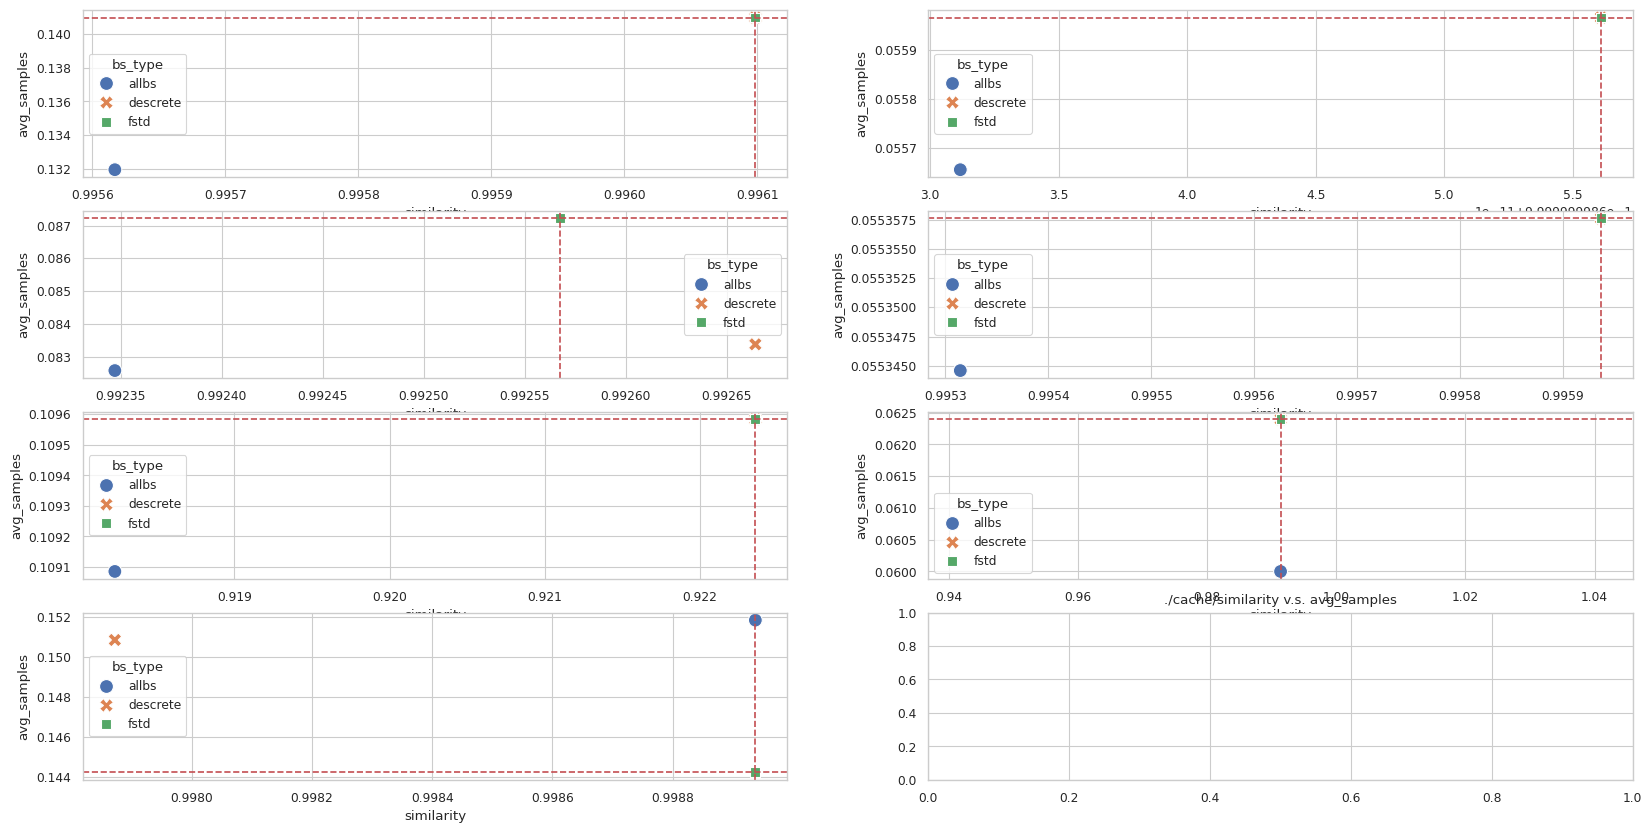

In [60]:
def plot_vary_bs_type(task_name: str, ax: plt.Axes):
    model = task_meta[task_name]['model']
    agg_qids = task_meta[task_name]['agg_ids']

    cmd = f"cd /home/ckchang/ApproxInfer/apxinfer/examples && python evaluate_all.py --exp {task_name} --model {model} --phase biathlon-bs_type"
    result = subprocess.run(cmd, capture_output=True, text=True, shell=True, check=True)
    stdout = result.stdout
    eval_paths = [s.replace('skip ', '') for s in stdout.split('\n')]
    eval_paths = [p for p in eval_paths if p != '']
    df = extract_evals(eval_paths, agg_qids)
    df = df[df['pest'] == "biathlon"][df['qinf'] == "biathlon"][df['scheduler'] == "optimizer"]

    keys = ['bs_type']
    df = df.sort_values(keys).set_index(keys)
    df = df[~df.index.duplicated(keep='first')]

    sns.scatterplot(data=df, x='similarity', y='avg_samples', hue='bs_type', style='bs_type', ax=ax, s=100)
    biathlon_biathlon_optimizer = df.loc[('fstd')]
    ax.axvline(biathlon_biathlon_optimizer['similarity'], color='r', linestyle='--')
    ax.axhline(biathlon_biathlon_optimizer['avg_samples'], color='r', linestyle='--')

fig, axes = plt.subplots(figsize=(20, 10), nrows=4, ncols=2)
axes = axes.flatten()
for i, task_name in enumerate(tasks):
    plot_vary_bs_type(task_name, axes[i])

os.makedirs('./cache', exist_ok=True)
plt.title(f'./cache/similarity v.s. avg_samples')
plt.savefig(f'./cache/vary_bs_type.png')
plt.show()